# Titan Company Annual Report NLP Pipeline (2023-24)

A clean, modular NLP workflow tailored to the Titan Company annual report. The notebook:
- Loads the PDF and stores each page in a DataFrame
- Applies robust preprocessing (normalization, cleaning, stopwords, lemmatization)
- Computes sentence-level sentiment using TextBlob
- Tokenizes words, explores frequent terms, and builds a wordcloud
- Creates TF‑IDF and a document-term matrix
- Trains a 10-topic LDA model (Gensim)
- Exports artifacts for a separate Streamlit FAQ chatbot (`titan_faq_app.py`)


In [1]:
# --- Environment and Imports ---
import sys
import subprocess

# Ensure required packages are available (idempotent installs)
for pkg in [
    "numpy", "pandas", "nltk", "textblob", "wordcloud", "PyMuPDF",
    "scikit-learn", "gensim", "matplotlib"
]:
    try:
        __import__(pkg.replace('-', '_'))
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", pkg])

import re
import json
import numpy as np
import pandas as pd
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from textblob import TextBlob

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from gensim import corpora

# Download NLTK resources (safe if already present)
for resource in ["punkt", "stopwords", "wordnet"]:
    try:
        nltk.data.find(f"tokenizers/{resource}")
    except LookupError:
        nltk.download(resource)

print("Environment ready.")


Environment ready.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rudra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rudra\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# --- Load PDF into DataFrame ---
from pathlib import Path

pdf_path = Path(r"C:\Users\rudra\Desktop\nlpp\proj\Titan Annual Report 2023-24 - 21MB 3.pdf")
assert pdf_path.exists(), f"PDF not found at: {pdf_path}"

with fitz.open(str(pdf_path)) as doc:
    pages = [
        {"page_number": i + 1, "text": doc.load_page(i).get_text()}
        for i in range(len(doc))
    ]

df_pages = pd.DataFrame(pages)
print("Pages loaded:", len(df_pages))
df_pages.head()


Pages loaded: 450


,page_number,text
0,1,40TH ANNUAL REPORT \n2023-24\ntowards the FUTU...
1,2,Investor Information\nCIN\nL74999TZ1984PLC0014...
2,3,ACROSS THE PAGES\n03-112\n113-262\nTurbochargi...
3,4,The Queen’s Collection by Taneira\nPower Pearl...
4,5,towards the FUTURE\nTurbocharging towards \nth...


In [3]:
# --- Text Preprocessing Utilities ---
STOP_WORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

_clean_re_list = [
    (re.compile(r"\s+"), " "),               # collapse whitespace
    (re.compile(r"\d+"), " "),               # remove digits
    (re.compile(r"[^a-zA-Z\s]"), " "),      # remove punctuation/specials
]

def normalize(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    for pattern, repl in _clean_re_list:
        text = pattern.sub(repl, text)
    return re.sub(r"\s+", " ", text).strip()


def remove_stopwords(tokens):
    return [t for t in tokens if t not in STOP_WORDS and len(t) > 2]


def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(t) for t in tokens]


def preprocess_document(text: str) -> str:
    base = normalize(text)
    tokens = word_tokenize(base)
    tokens = remove_stopwords(tokens)
    tokens = lemmatize_tokens(tokens)
    return " ".join(tokens)

# Apply to each page
df_pages['processed_text'] = df_pages['text'].apply(preprocess_document)
print("Preprocessing complete.")
df_pages[['page_number','processed_text']].head()


Preprocessing complete.


,page_number,processed_text
0,1,annual report towards future titan company lim...
1,2,investor information cin plc bse code nse symb...
2,3,across page turbocharging towards future titan...
3,4,queen collection taneira power pearl collectio...
4,5,towards future turbocharging towards future en...


In [4]:
# --- Sentence Tokenization & Sentiment ---
sentiment_rows = []
for _, row in df_pages.iterrows():
    sentences = sent_tokenize(row['text'] or "")
    for sent in sentences:
        blob = TextBlob(sent)
        sentiment_rows.append({
            "page_number": row['page_number'],
            "sentence": sent.strip(),
            "polarity": float(blob.sentiment.polarity),
            "subjectivity": float(blob.sentiment.subjectivity),
        })

sentiment_df = pd.DataFrame(sentiment_rows)

print("Sentences:", len(sentiment_df))
sentiment_df.head(10)


Sentences: 5208


,page_number,sentence,polarity,subjectivity
0,1,40TH ANNUAL REPORT \n2023-24\ntowards the FUTU...,-0.035714,0.133929
1,2,Investor Information\nCIN\nL74999TZ1984PLC0014...,-0.057143,0.222619
2,2,"By their nature, forward-looking statements re...",-0.166667,0.333333
3,2,There is a significant risk that the assumptio...,0.216667,0.627778
4,2,Readers are cautioned not to place undue relia...,0.000000,0.075000
5,2,"Accordingly, this \ndocument is subject to the...",-0.166667,0.333333
6,2,Scan Me\nExplore our brands on our website:\nt...,0.000000,0.000000
7,3,ACROSS THE PAGES\n03-112\n113-262\nTurbochargi...,0.046667,0.150833
8,4,The Queen’s Collection by Taneira\nPower Pearl...,0.000000,0.000000
9,5,towards the FUTURE\nTurbocharging towards \nth...,0.111111,0.305556


Top 25 tokens:
[('company', 1838), ('year', 1624), ('financial', 1592), ('report', 884), ('march', 863), ('limited', 837), ('statement', 798), ('crore', 615), ('titan', 605), ('asset', 596), ('director', 591), ('annual', 535), ('value', 478), ('note', 434), ('board', 428), ('share', 426), ('corporate', 400), ('group', 375), ('ended', 371), ('liability', 360), ('loss', 348), ('total', 342), ('employee', 336), ('tata', 336), ('entity', 320)]


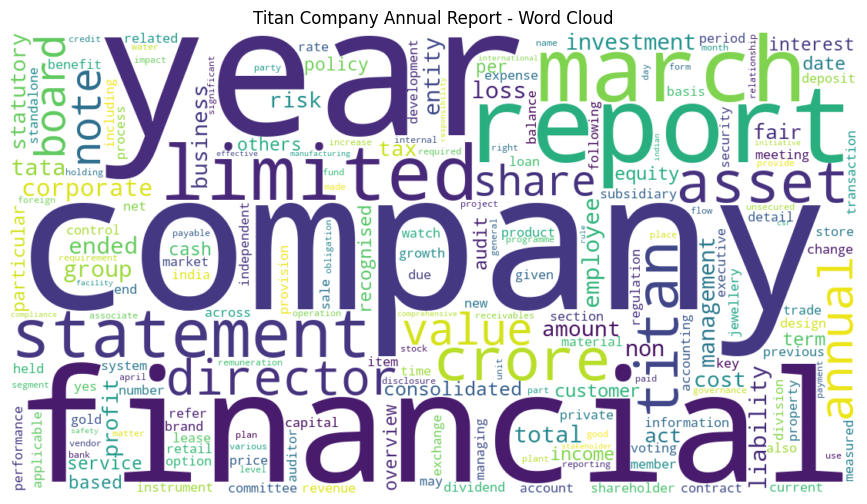

In [5]:
# --- Word Frequencies & Wordcloud ---
from nltk.probability import FreqDist

all_tokens = " ".join(df_pages['processed_text'].tolist())
all_tokens = word_tokenize(all_tokens)
fdist = FreqDist(all_tokens)

print("Top 25 tokens:")
print(fdist.most_common(25))

wc = WordCloud(
    width=1100,
    height=600,
    background_color="white",
    colormap="viridis",
).generate_from_frequencies(fdist)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Titan Company Annual Report - Word Cloud")
plt.show()


In [6]:
# --- TF-IDF and Document-Term Matrix ---
corpus_documents = df_pages['processed_text'].tolist()

vectorizer = TfidfVectorizer(max_features=1500, min_df=2)
tfidf_matrix = vectorizer.fit_transform(corpus_documents)

print("TF-IDF shape:", tfidf_matrix.shape)

# Persist artifacts for chatbot usage
chatbot_payload = {
    "pages": df_pages[['page_number', 'text']].to_dict(orient='records'),
    "vocabulary": vectorizer.vocabulary_,
    "tfidf_matrix": tfidf_matrix.toarray().tolist(),
}

# Ensure all numpy/scikit types are JSON serializable

def convert_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_types(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_types(i) for i in obj]
    return obj

serializable_payload = convert_types(chatbot_payload)

with open('titan_chatbot_data.json', 'w', encoding='utf-8') as f:
    json.dump(serializable_payload, f, ensure_ascii=False, indent=2)

print("Saved titan_chatbot_data.json")


TF-IDF shape: (450, 1500)
Saved titan_chatbot_data.json


In [ ]:
# --- LDA Topic Modeling (10 topics) ---
# Prepare tokens list for Gensim
page_tokens = [word_tokenize(txt) for txt in df_pages['processed_text']]

# Build dictionary and corpus
dictionary = corpora.Dictionary(page_tokens)
corpus = [dictionary.doc2bow(tokens) for tokens in page_tokens]

print(f"Dictionary size: {len(dictionary)}")
print(f"Corpus size: {len(corpus)}")

lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=123,
    update_every=1,
    chunksize=150,
    passes=8,
    alpha='auto',
    per_word_topics=True,
)

print("LDA Model Topics:")
for idx, topic in lda_model.print_topics(num_topics=10, num_words=12):
    print(f"Topic {idx}: {topic}")

# Verify the model has exactly 10 topics
print(f"\nModel has {lda_model.num_topics} topics")


Topic 0: 0.036*"company" + 0.022*"share" + 0.021*"limited" + 0.018*"year" + 0.013*"subsidiary" + 0.011*"march" + 0.011*"titan" + 0.011*"report" + 0.010*"investment" + 0.009*"crore" + 0.009*"others" + 0.009*"credit"
Topic 1: 0.020*"brand" + 0.018*"year" + 0.017*"titan" + 0.015*"growth" + 0.013*"store" + 0.011*"product" + 0.011*"watch" + 0.010*"division" + 0.010*"customer" + 0.010*"jewellery" + 0.010*"segment" + 0.009*"retail"
Topic 2: 0.020*"employee" + 0.018*"permanent" + 0.014*"worker" + 0.011*"csr" + 0.010*"female" + 0.009*"total" + 0.009*"impact" + 0.009*"programme" + 0.009*"wage" + 0.009*"year" + 0.009*"education" + 0.009*"woman"
Topic 3: 0.110*"limited" + 0.074*"tata" + 0.038*"group" + 0.031*"entity" + 0.028*"private" + 0.014*"titan" + 0.012*"service" + 0.010*"development" + 0.009*"company" + 0.008*"promoter" + 0.007*"son" + 0.007*"power"
Topic 4: 0.041*"financial" + 0.034*"year" + 0.018*"company" + 0.017*"report" + 0.013*"yes" + 0.013*"property" + 0.013*"audit" + 0.012*"control" 

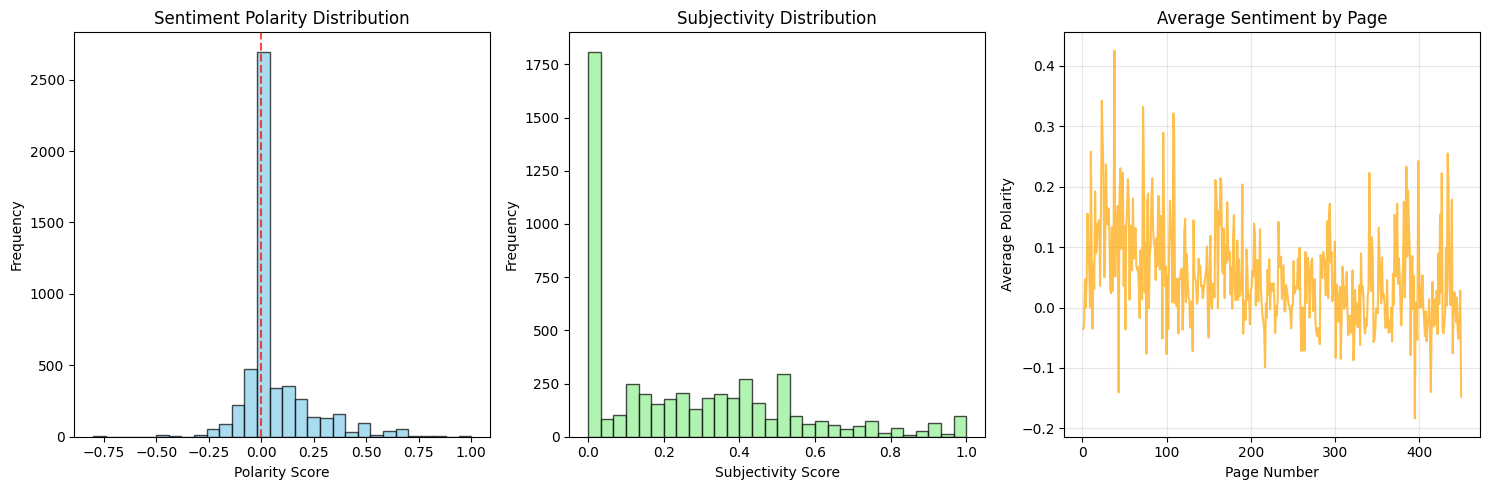

Sentiment Analysis Summary:
Average Polarity: 0.059
Average Subjectivity: 0.254
Most Positive Sentence: This enables us to offer timely, personalised 
suggestions, enhancing our customers’ shopping 
exper...
Most Negative Sentence: Additionally, we closely monitor design trends to stay ahead 
of evolving consumer preferences with ...


In [8]:
# --- Sentiment Analysis Visualization ---
plt.figure(figsize=(15, 5))

# Plot 1: Sentiment Distribution
plt.subplot(1, 3, 1)
plt.hist(sentiment_df['polarity'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)

# Plot 2: Subjectivity Distribution
plt.subplot(1, 3, 2)
plt.hist(sentiment_df['subjectivity'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Subjectivity Distribution')
plt.xlabel('Subjectivity Score')
plt.ylabel('Frequency')

# Plot 3: Sentiment by Page
plt.subplot(1, 3, 3)
page_sentiment = sentiment_df.groupby('page_number')['polarity'].mean()
plt.plot(page_sentiment.index, page_sentiment.values, alpha=0.7, color='orange')
plt.title('Average Sentiment by Page')
plt.xlabel('Page Number')
plt.ylabel('Average Polarity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("Sentiment Analysis Summary:")
print(f"Average Polarity: {sentiment_df['polarity'].mean():.3f}")
print(f"Average Subjectivity: {sentiment_df['subjectivity'].mean():.3f}")
print(f"Most Positive Sentence: {sentiment_df.loc[sentiment_df['polarity'].idxmax(), 'sentence'][:100]}...")
print(f"Most Negative Sentence: {sentiment_df.loc[sentiment_df['polarity'].idxmin(), 'sentence'][:100]}...")


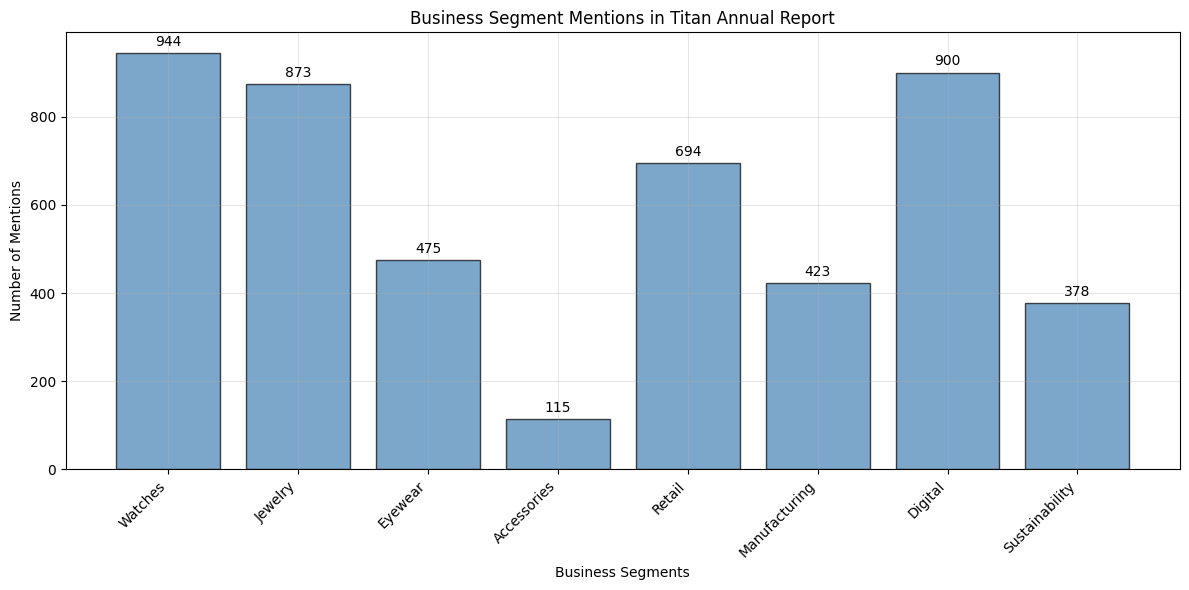

Business Segment Analysis:
Watches: 944 mentions
Jewelry: 873 mentions
Eyewear: 475 mentions
Accessories: 115 mentions
Retail: 694 mentions
Manufacturing: 423 mentions
Digital: 900 mentions
Sustainability: 378 mentions


In [9]:
# --- Business Segment Analysis ---
# Define keywords for different business segments
business_segments = {
    'Watches': ['watch', 'timepiece', 'titan', 'fastrack', 'sonata', 'xylys', 'movement', 'dial', 'strap'],
    'Jewelry': ['jewelry', 'jewellery', 'tanishq', 'mia', 'caratlane', 'gold', 'diamond', 'ring', 'necklace', 'bracelet'],
    'Eyewear': ['eyewear', 'eyeplus', 'spectacle', 'lens', 'frame', 'vision', 'optical', 'sunglass'],
    'Accessories': ['accessory', 'bag', 'wallet', 'belt', 'lifestyle', 'fashion'],
    'Retail': ['retail', 'store', 'outlet', 'shop', 'customer', 'sales', 'revenue'],
    'Manufacturing': ['manufacturing', 'production', 'factory', 'facility', 'quality', 'process'],
    'Digital': ['digital', 'online', 'ecommerce', 'technology', 'app', 'website', 'platform'],
    'Sustainability': ['sustainability', 'environment', 'green', 'carbon', 'waste', 'renewable', 'energy']
}

# Analyze text for business segment mentions
segment_analysis = {}
for segment, keywords in business_segments.items():
    mentions = 0
    for text in df_pages['processed_text']:
        for keyword in keywords:
            mentions += text.lower().count(keyword.lower())
    segment_analysis[segment] = mentions

# Create visualization
plt.figure(figsize=(12, 6))
segments = list(segment_analysis.keys())
mentions = list(segment_analysis.values())

plt.bar(segments, mentions, color='steelblue', alpha=0.7, edgecolor='black')
plt.title('Business Segment Mentions in Titan Annual Report')
plt.xlabel('Business Segments')
plt.ylabel('Number of Mentions')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(mentions):
    plt.text(i, v + max(mentions) * 0.01, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("Business Segment Analysis:")
for segment, count in segment_analysis.items():
    print(f"{segment}: {count} mentions")


Number of topic distributions: 450
Length of first distribution: 10
DataFrame shape: (450, 11)


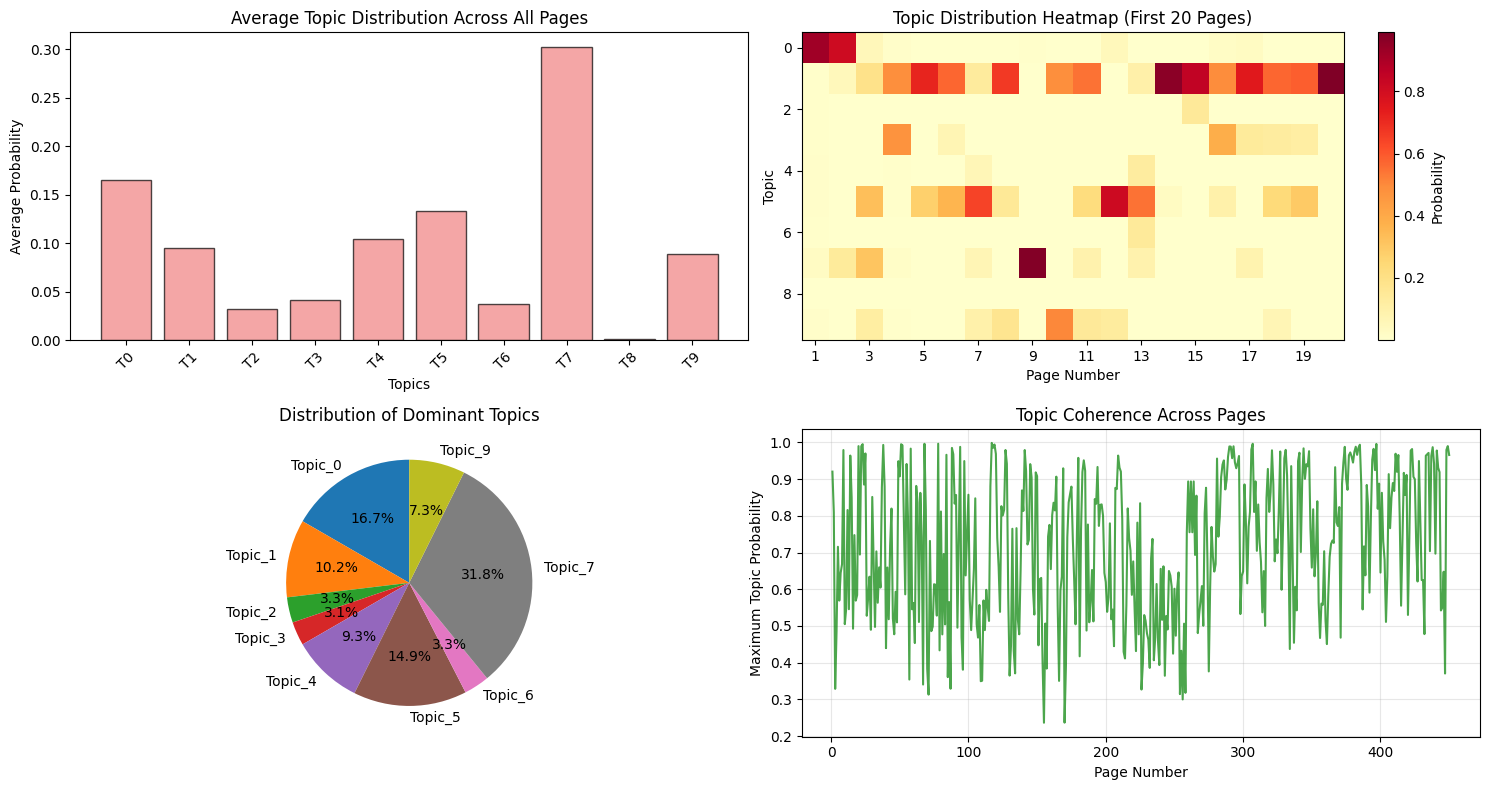

Topic Analysis Summary:
Most prevalent topic: Topic_Topic_7
Least prevalent topic: Topic_Topic_8
Average topic coherence: 0.718


In [14]:
# --- Topic Distribution Analysis ---
# Get topic distribution for each document
topic_distributions = []

# Method 1: Try to get all 10 topics with minimum probability
for doc in corpus:
    topic_dist = lda_model.get_document_topics(doc, minimum_probability=0.0)  # Changed to 0.0
    # Ensure we have exactly 10 topics (pad with zeros if needed)
    topic_probs = [0.0] * 10
    for topic_id, prob in topic_dist:
        if topic_id < 10:  # Safety check
            topic_probs[topic_id] = prob
    topic_distributions.append(topic_probs)

# Verify we have the right number of columns
print(f"Number of topic distributions: {len(topic_distributions)}")
print(f"Length of first distribution: {len(topic_distributions[0]) if topic_distributions else 0}")

topic_dist_df = pd.DataFrame(topic_distributions, columns=[f'Topic_{i}' for i in range(10)])

# Add page numbers
topic_dist_df['page_number'] = df_pages['page_number'].values

print(f"DataFrame shape: {topic_dist_df.shape}")

# Visualize topic distributions
plt.figure(figsize=(15, 8))

# Plot 1: Average topic distribution across all pages
plt.subplot(2, 2, 1)
avg_topic_dist = topic_dist_df.drop('page_number', axis=1).mean()
topics = [f'T{i}' for i in range(10)]
plt.bar(topics, avg_topic_dist.values, color='lightcoral', alpha=0.7, edgecolor='black')
plt.title('Average Topic Distribution Across All Pages')
plt.xlabel('Topics')
plt.ylabel('Average Probability')
plt.xticks(rotation=45)

# Plot 2: Topic distribution heatmap (first 20 pages)
plt.subplot(2, 2, 2)
heatmap_data = topic_dist_df.drop('page_number', axis=1).head(20).T
plt.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
plt.colorbar(label='Probability')
plt.title('Topic Distribution Heatmap (First 20 Pages)')
plt.xlabel('Page Number')
plt.ylabel('Topic')
plt.xticks(range(0, 20, 2), range(1, 21, 2))

# Plot 3: Dominant topic per page
plt.subplot(2, 2, 3)
dominant_topics = topic_dist_df.drop('page_number', axis=1).idxmax(axis=1)
topic_counts = dominant_topics.value_counts().sort_index()
labels = topic_counts.index.tolist()
values = topic_counts.values
if len(labels) == 0:
    plt.text(0.5, 0.5, 'No dominant topics', ha='center', va='center')
else:
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Dominant Topics')

# Plot 4: Topic coherence over pages
plt.subplot(2, 2, 4)
topic_coherence = topic_dist_df.drop('page_number', axis=1).max(axis=1)
plt.plot(topic_dist_df['page_number'], topic_coherence, alpha=0.7, color='green')
plt.title('Topic Coherence Across Pages')
plt.xlabel('Page Number')
plt.ylabel('Maximum Topic Probability')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Topic Analysis Summary:")
print(f"Most prevalent topic: Topic_{avg_topic_dist.idxmax()}")
print(f"Least prevalent topic: Topic_{avg_topic_dist.idxmin()}")
print(f"Average topic coherence: {topic_coherence.mean():.3f}")


In [15]:
# --- Export Additional Analysis Results ---
# Save sentiment analysis results
sentiment_summary = {
    'total_sentences': len(sentiment_df),
    'average_polarity': float(sentiment_df['polarity'].mean()),
    'average_subjectivity': float(sentiment_df['subjectivity'].mean()),
    'positive_sentences': int(len(sentiment_df[sentiment_df['polarity'] > 0.1])),
    'negative_sentences': int(len(sentiment_df[sentiment_df['polarity'] < -0.1])),
    'neutral_sentences': int(len(sentiment_df[(sentiment_df['polarity'] >= -0.1) & (sentiment_df['polarity'] <= 0.1)]))
}

# Save business segment analysis
business_analysis = {
    'segment_mentions': segment_analysis,
    'total_pages': len(df_pages),
    'total_words': sum(len(text.split()) for text in df_pages['processed_text']),
    'unique_words': len(set(' '.join(df_pages['processed_text']).split()))
}

# Save topic analysis
topic_analysis = {
    'num_topics': 10,
    'average_topic_coherence': float(topic_coherence.mean()),
    'most_prevalent_topic': f"Topic_{avg_topic_dist.idxmax()}",
    'least_prevalent_topic': f"Topic_{avg_topic_dist.idxmin()}",
    'topic_distributions': topic_dist_df.to_dict(orient='records')
}

# Combine all analysis results
analysis_results = {
    'sentiment_analysis': sentiment_summary,
    'business_analysis': business_analysis,
    'topic_analysis': topic_analysis,
    'word_frequencies': dict(fdist.most_common(50)),
    'lda_topics': {f"topic_{i}": topic for i, topic in enumerate(lda_model.print_topics(num_topics=10, num_words=10))}
}

# Save comprehensive analysis results
with open('titan_analysis_results.json', 'w', encoding='utf-8') as f:
    json.dump(analysis_results, f, ensure_ascii=False, indent=2)

print("Analysis complete! Files saved:")
print("✓ titan_chatbot_data.json - For FAQ chatbot")
print("✓ titan_analysis_results.json - Comprehensive analysis results")
print("\nSummary:")
print(f"📄 Pages processed: {len(df_pages)}")
print(f"📝 Sentences analyzed: {len(sentiment_df)}")
print(f"📊 Topics identified: 10")
print(f"💬 Average sentiment: {sentiment_df['polarity'].mean():.3f}")
print(f"🏢 Business segments analyzed: {len(business_segments)}")


Analysis complete! Files saved:
✓ titan_chatbot_data.json - For FAQ chatbot
✓ titan_analysis_results.json - Comprehensive analysis results

Summary:
📄 Pages processed: 450
📝 Sentences analyzed: 5208
📊 Topics identified: 10
💬 Average sentiment: 0.059
🏢 Business segments analyzed: 8
